<a href="https://colab.research.google.com/github/himanshudas13/Land-Use-Land-Cover/blob/master/Land-Use-Land-Cover%20/Prediction/GRIDsearchipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tensorflow scikit-learn
!pip install scikeras

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, LSTM, TimeDistributed, Dense, Reshape, Input,Flatten, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from PIL import Image, ImageDraw
import os
import matplotlib.pyplot as plt
import cv2
import os
import numpy as np
from tensorflow.keras import layers, models
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, MaxPooling2D, Dense, Flatten, Reshape, Input
from tensorflow.keras.models import Model


In [ ]:

# Define the width, height, and the number of images
width, height = 200, 200
num_images = 40
step = width // num_images

# Define the folder path
folder_path = "/content/Rectangles"

# Create the folder if it doesn't exist
os.makedirs(folder_path, exist_ok=True)

# Loop through and create each image
for i in range(num_images):
    # Create a new white image
    img = Image.new('RGB', (width, height), color='red')
    draw = ImageDraw.Draw(img)

    # Draw a black rectangle with increasing size
    draw.rectangle([0, 0, step * (i + 1), height], fill='black')

    # Save the image in the specified folder
    img.save(f"{folder_path}/image_{i + 1:02d}.png")


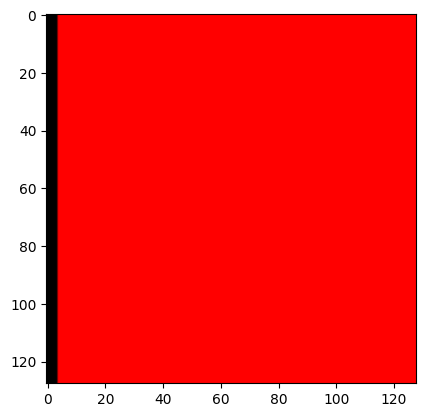

0.0 n 1.0


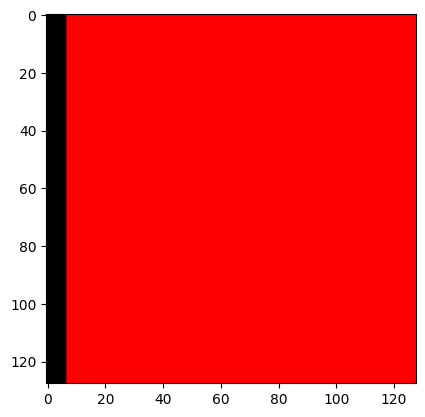

0.0 n 1.0


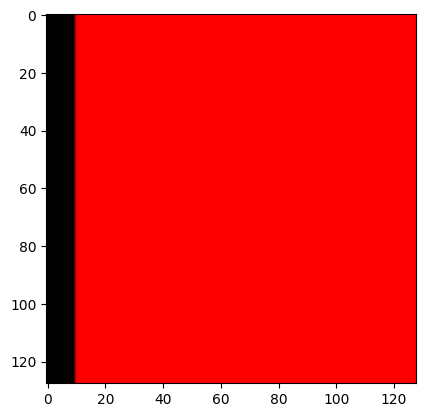

0.0 n 1.0


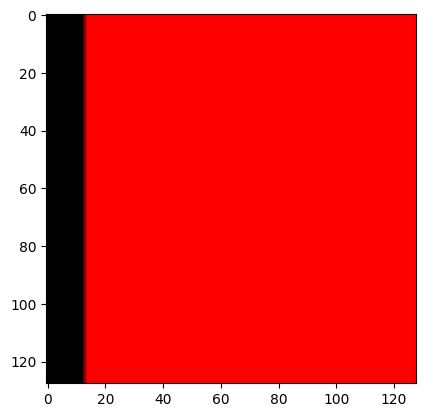

0.0 n 1.0


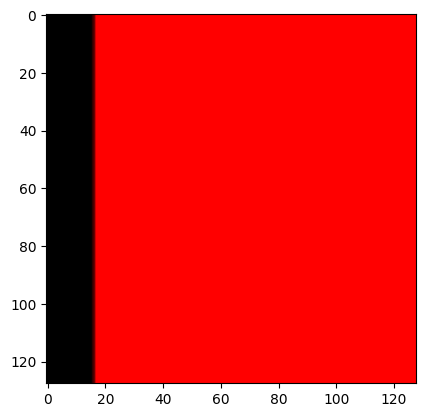

0.0 n 1.0


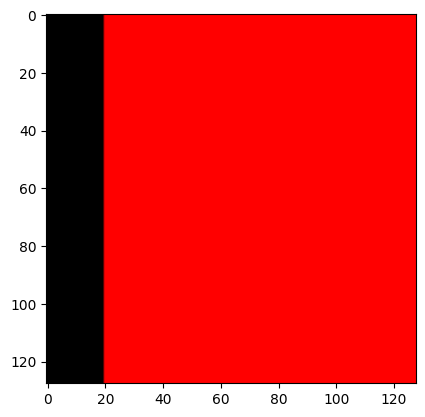

0.0 n 1.0


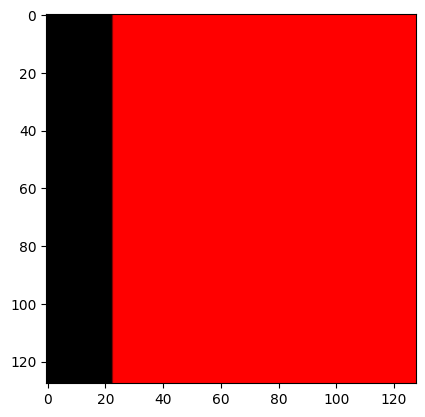

0.0 n 1.0


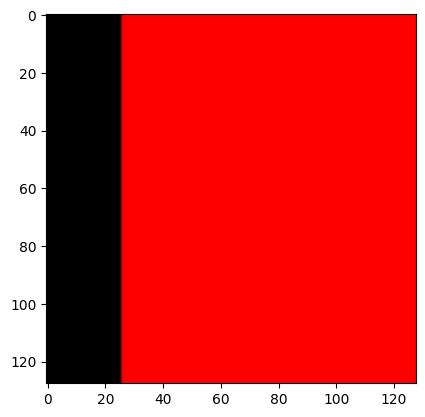

0.0 n 1.0


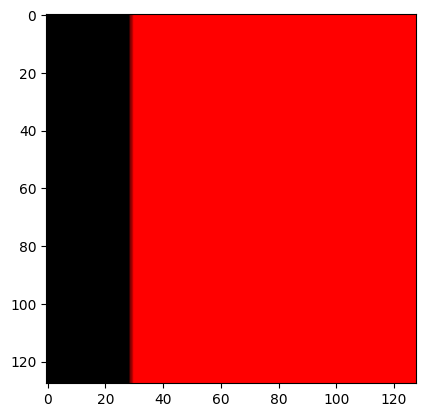

0.0 n 1.0


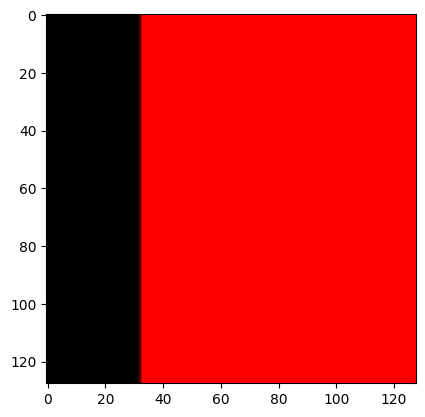

0.0 n 1.0


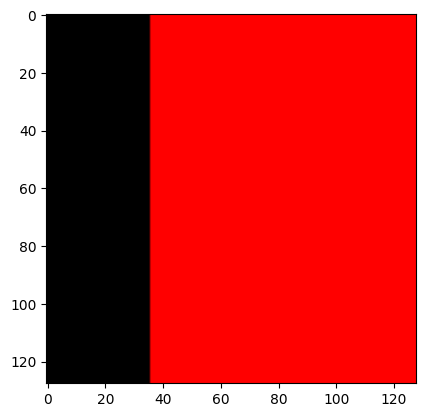

0.0 n 1.0


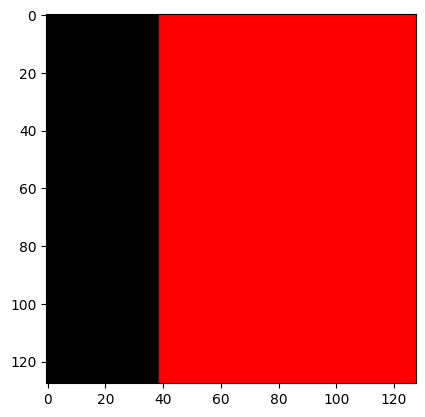

0.0 n 1.0


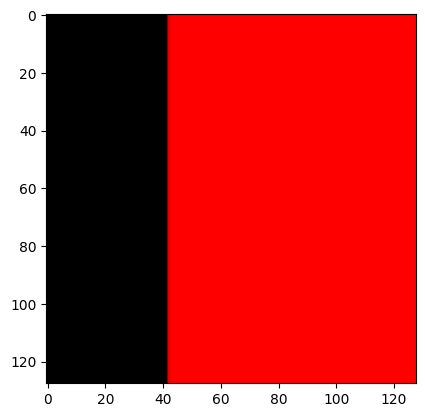

0.0 n 1.0


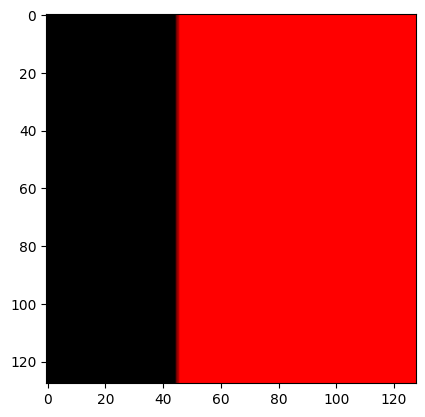

0.0 n 1.0


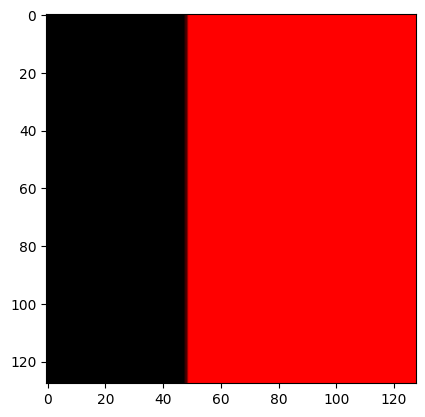

0.0 n 1.0


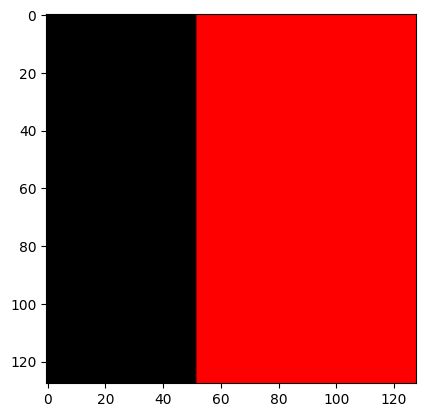

0.0 n 1.0


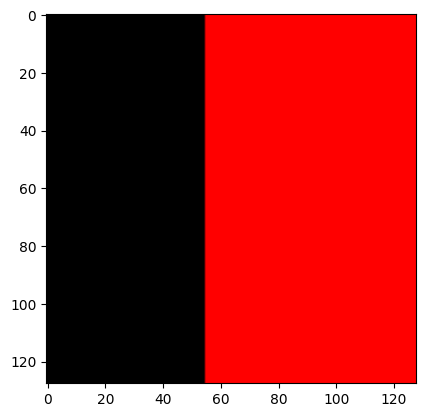

0.0 n 1.0


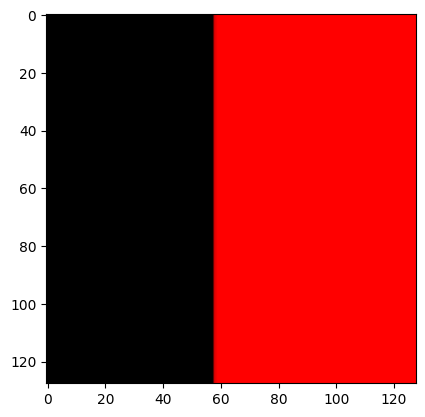

0.0 n 1.0


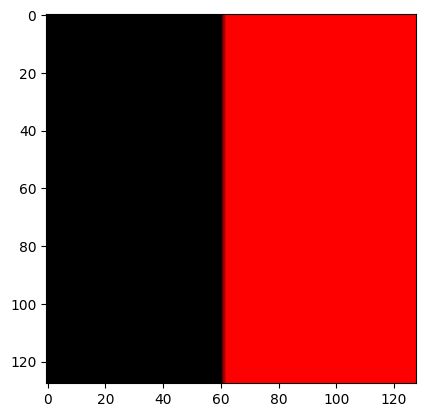

0.0 n 1.0


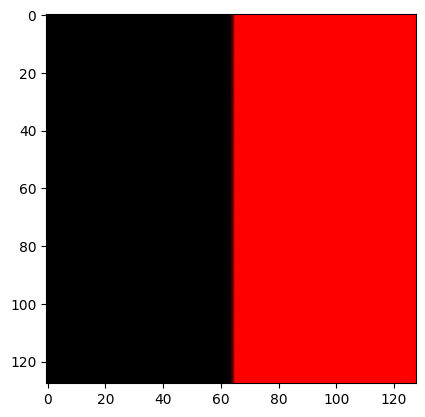

0.0 n 1.0


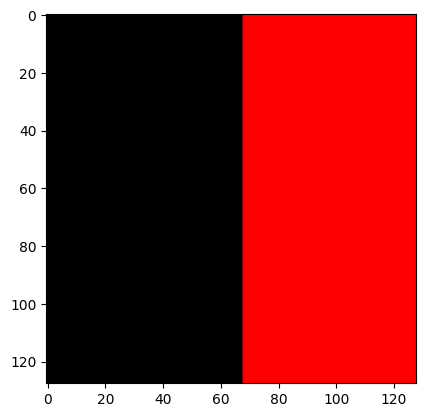

0.0 n 1.0


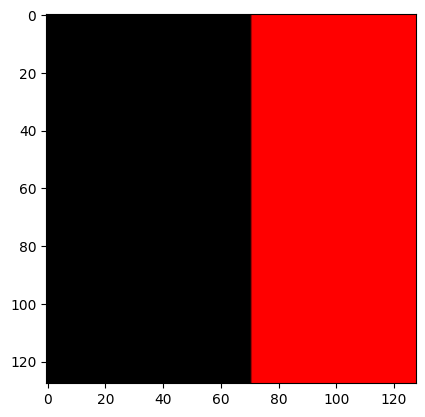

0.0 n 1.0


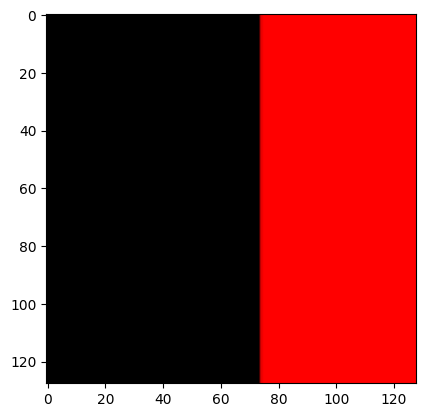

0.0 n 1.0


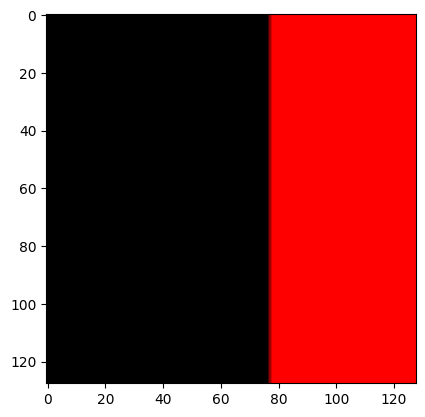

0.0 n 1.0


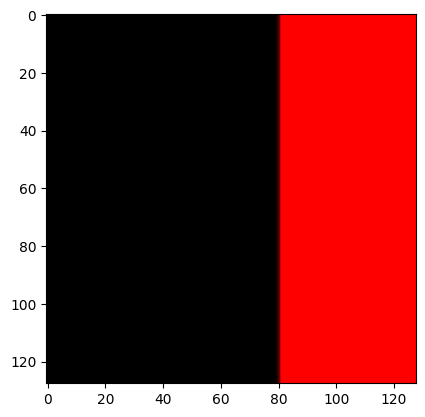

0.0 n 1.0


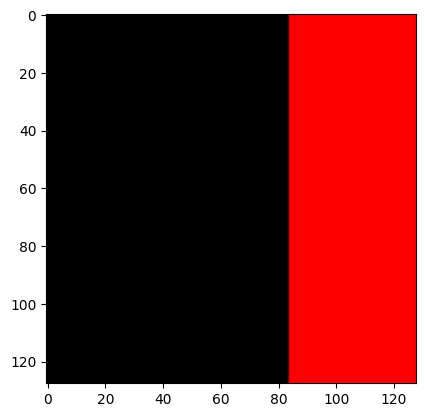

0.0 n 1.0


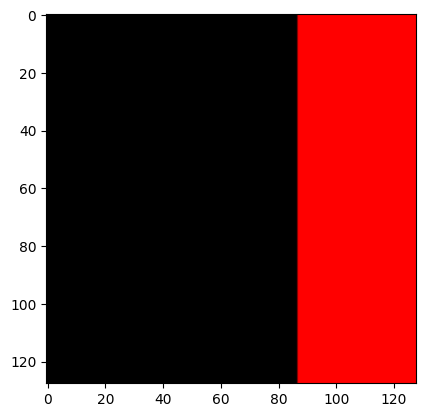

0.0 n 1.0


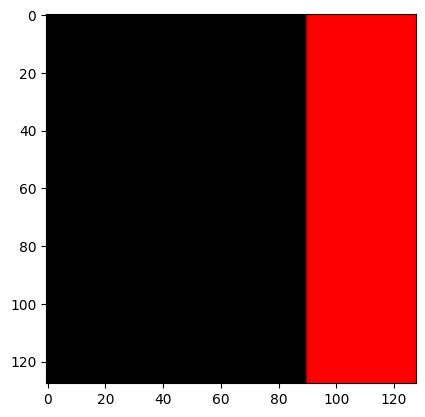

0.0 n 1.0


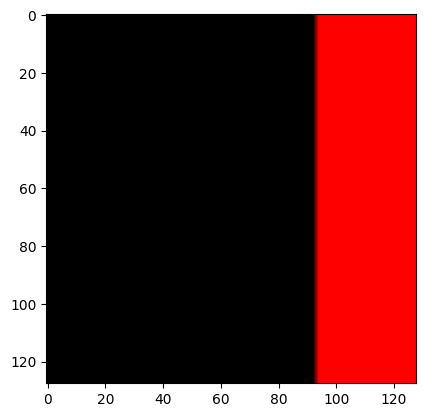

0.0 n 1.0


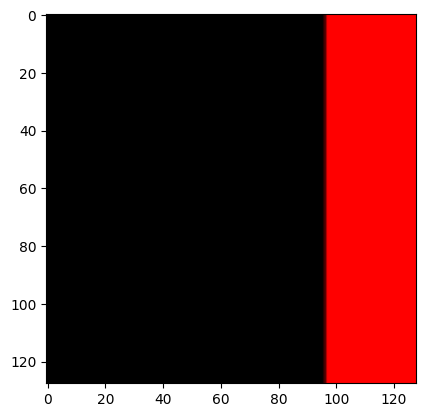

0.0 n 1.0


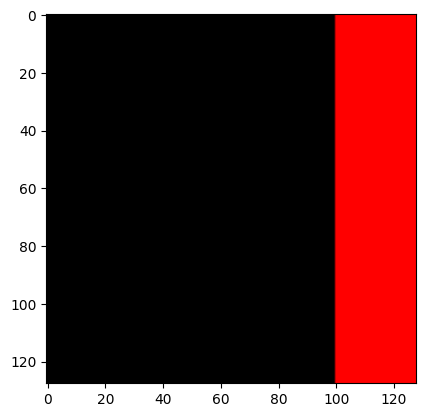

0.0 n 1.0


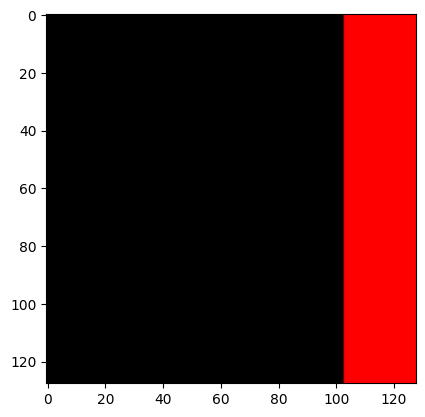

0.0 n 1.0


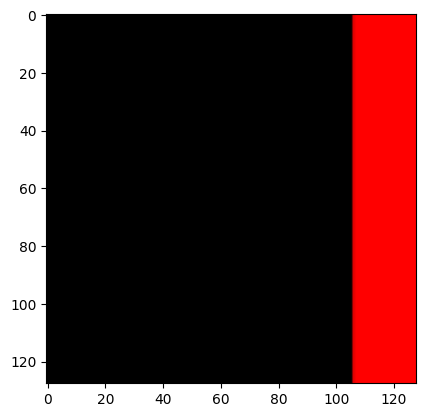

0.0 n 1.0


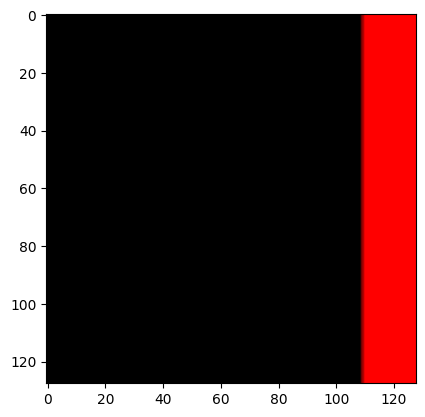

0.0 n 1.0


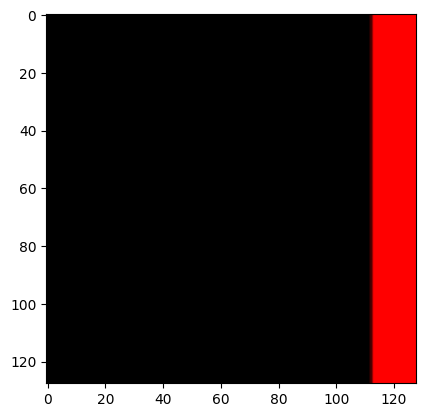

0.0 n 1.0


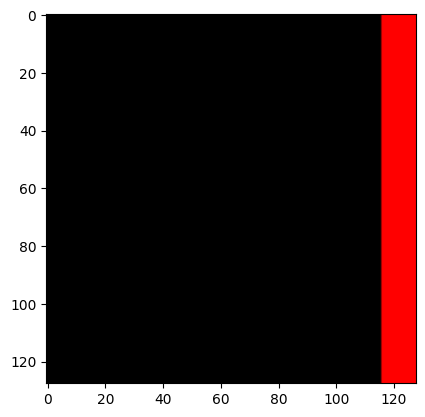

0.0 n 1.0


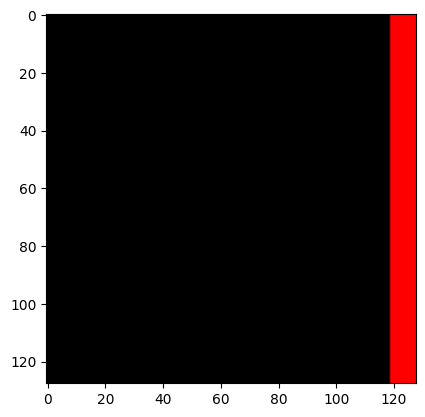

0.0 n 1.0


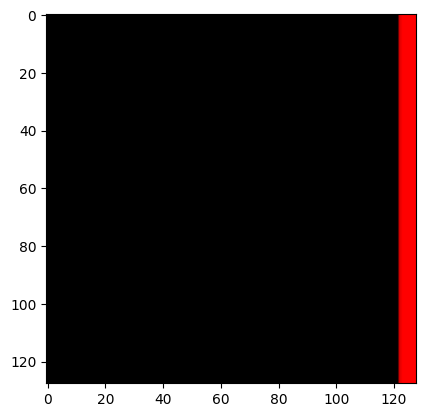

0.0 n 1.0


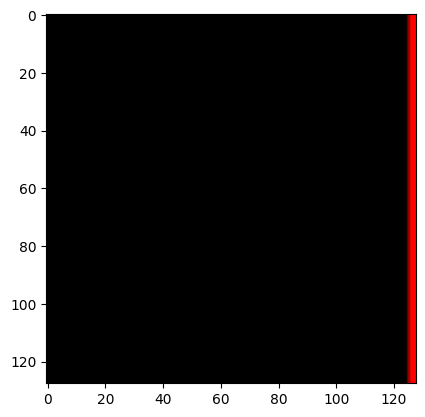

0.0 n 1.0


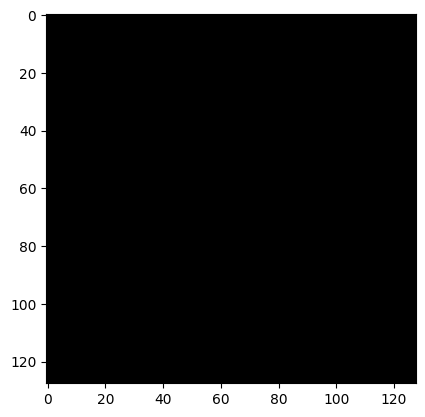

0.0 n 0.0


In [ ]:
input_shape = (128, 128, 3)  # Desired shape of input images
time_steps = 2  # Number of time steps in the series
data_dir = '/content/Rectangles'

def load_and_preprocess_images(data_dir, input_shape):
    images = []
    for filename in sorted(os.listdir(data_dir)):
        if filename.endswith('.jpg') or filename.endswith('.png'):
            img_path = os.path.join(data_dir, filename)
            img = cv2.imread(img_path)
            img = cv2.resize(img, (input_shape[0], input_shape[1]))
            plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))  # Convert from BGR to RGB for Matplotlib
            plt.show()
            img = img / 255.0  # Normalize to [0, 1]
            print(f'{img.min()} n {img.max()}')

            images.append(img)
    return np.array(images)

# Load images
images = load_and_preprocess_images(data_dir, input_shape)




In [ ]:
split_index = int(30)
image_train=images[:split_index]
image_test=images[split_index:]
print(image_train.shape)
print(image_test.shape)


(30, 128, 128, 3)
(10, 128, 128, 3)


In [ ]:
def prepare_data_for_lstm( encoded_features, time_steps):

    # Prepare time series data
    X, y = [], []
    for i in range(len(encoded_features) - time_steps):
        # Input sequence (time_steps images)
        X.append(encoded_features[i:i + time_steps])

        # Output (next feature vector or target)
        y.append(encoded_features[i + time_steps])

    return np.array(X), np.array(y)


In [ ]:
X_train, y_train = prepare_data_for_lstm(image_train, time_steps)
print(X_train.shape)
print(y_train.shape)

(28, 2, 128, 128, 3)
(28, 128, 128, 3)


In [ ]:
X_test, y_test = prepare_data_for_lstm(image_test, time_steps)
print(X_test.shape)
print(y_test.shape)

(8, 2, 128, 128, 3)
(8, 128, 128, 3)


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, LSTM, Reshape, Conv2DTranspose
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.model_selection import GridSearchCV

class CustomRegressor(BaseEstimator, RegressorMixin):
    def __init__(self, num_cnn_layers=1, cnn_filters=[8, 16], dense_units=32, num_lstm_layers=2,
                 lstm_units=[16, 32], num_decoder_layers=1, decoder_filters=[64, 32],
                 learning_rate=0.001, batch_size=10, epochs=80):
        self.num_cnn_layers = num_cnn_layers
        self.cnn_filters = cnn_filters
        self.dense_units = dense_units
        self.num_lstm_layers = num_lstm_layers
        self.lstm_units = lstm_units
        self.num_decoder_layers = num_decoder_layers
        self.decoder_filters = decoder_filters
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.epochs = epochs
        self.model = None
    def create_cnn_encoder(input_shape, num_cnn_layers=3, cnn_filters=None, dense_units=32):
         if cnn_filters is None:
          cnn_filters = [8, 16, 32]  # Default filter sizes for 3 layers

         model = models.Sequential()
         model.add(layers.InputLayer(input_shape=input_shape))

         for i in range(num_cnn_layers):
          model.add(layers.TimeDistributed(layers.Conv2D(cnn_filters[i], (3, 3), activation='relu', padding='same')))
          model.add(layers.TimeDistributed(layers.MaxPooling2D((2, 2))))

         model.add(layers.TimeDistributed(layers.Flatten()))
         model.add(layers.TimeDistributed(layers.Dense(dense_units, activation='relu')))

         return model

    def create_lstm_model(encoded_feature_shape, time_steps, num_lstm_layers=3, lstm_units=None):
      if lstm_units is None:
         lstm_units = [16, 8, 32]  # Default units for 3 layers

      model = models.Sequential()
      model.add(layers.Input(shape=(time_steps, *encoded_feature_shape)))

      for i in range(num_lstm_layers):
         model.add(layers.SimpleRNN(lstm_units[i], return_sequences=(i < num_lstm_layers - 1), activation='relu'))

      return model

    def create_decoder_model(lstm_output_shape, output_shape, num_decoder_layers=3, decoder_filters=None):
      if decoder_filters is None:
         decoder_filters = [64, 32, 16]  # Default filters for 3 layers

      model = models.Sequential()
      model.add(layers.InputLayer(input_shape=(lstm_output_shape,)))

       # Dense Layer to expand back to a higher-dimensional feature map
      model.add(layers.Dense(16 * 16 * decoder_filters[0], activation='relu'))  # Adjust size to match the intermediate feature map size
      model.add(layers.Reshape((16, 16, decoder_filters[0])))

      for i in range(num_decoder_layers):
        model.add(layers.UpSampling2D((2, 2)))
        model.add(layers.Conv2D(decoder_filters[i], (3, 3), activation='relu', padding='same'))

      model.add(layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same'))  # Final layer to output 128x128x3

      return model
    def create_full_model(num_cnn_layers=3,cnn_filters=None, num_lstm_layers=3, num_decoder_layers=3, lstm_units=None,
                      decoder_filters=None, dense_units=32, learning_rate=0.001):

     cnn_encoder = create_cnn_encoder(input_shape, num_cnn_layers=num_cnn_layers, cnn_filters=cnn_filters, dense_units=dense_units)
     lstm_model = create_lstm_model(encoded_feature_shape=(dense_units,), time_steps=2, num_lstm_layers=num_lstm_layers, lstm_units=lstm_units)
     decoder_model = create_decoder_model(lstm_output_shape=lstm_units[-1], output_shape=(128, 128, 3),
                                         num_decoder_layers=num_decoder_layers, decoder_filters=decoder_filters)

     # Combine them to form the full model
     cnn_input = layers.Input(shape=input_shape)
     cnn_output = cnn_encoder(cnn_input)
     lstm_output = lstm_model(cnn_output)
     decoded_image = decoder_model(lstm_output)
     full_model = models.Model(inputs=cnn_input, outputs=decoded_image)

     optimizer = Adam(learning_rate=learning_rate)
     model.compile(optimizer=optimizer, loss='mean_squared_error')

     return model

    def fit(self, X, y):
        self.model = self.build_model()
        self.model.fit(X, y, batch_size=self.batch_size, epochs=self.epochs, verbose=2)
        return self

    def predict(self, X):
        if self.model is None:
            raise ValueError("Model is not trained yet.")
        return self.model.predict(X)

# Define the parameter grid
param_grid = {
    'num_cnn_layers': [1, 2, 3],
    'cnn_filters': [[8, 16], [8, 16, 32], [16, 32, 64]],
    'dense_units': [32, 64],
    'num_lstm_layers': [2, 3],
    'lstm_units': [[16, 32], [8, 16, 32], [4, 8, 32]],
    'num_decoder_layers': [1, 2, 3],
    'decoder_filters': [[64, 32], [64, 32, 16], [128, 64, 32]],
    'learning_rate': [0.001, 0.0001],
    'batch_size': [10, 15],
    'epochs': [80, 120]
}

# Create the GridSearchCV object
grid = GridSearchCV(estimator=CustomRegressor(), param_grid=param_grid, cv=3, verbose=2)

# Fit GridSearchCV (assuming X_train and y_train are your training data)
grid_result = grid.fit(X_train, y_train)  # Replace X_train and y_train with your actual data

# Print the best parameters and score
print(f"Best Score: {grid_result.best_score_}")
print(f"Best Params: {grid_result.best_params_}")
